# Compare PIP of susie, DAP and CAVIAR

DAP and CAVIAR is performed on some of the same input data and is compared with `susie`.

## Plan

Here I consider the following scenarios:

- Fix total PVE to 0.2
- Scenario with growing difficulty: from 1 causal to 5 causal

For CAVIAR I only try and report the 2 causal and 3 causal scenarios.

The plan is to get the PIP for those in susieR mappable CS (purity > 0.2), and compare these PIP to what DAP and CAVIAR reports. For susie flavors:

- use prior = 0.2
- use estimate_residule = False

This setting of susie should reflect its best performance. Additionally I check both the PIP computed before purity filter, and that after purity filter.

## Expected outcome

- PIP plots, 3-way: susie vs DAP, susie vs CAVIAR, DAP vs CAVIAR
- A coarse ROC plot: report signals identified vs signal missed -- number of causal, under the same PVE setup.

In [1]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

Frontend communicator is broken. Please restart jupyter server


Previously I've ran this specific DSC using:

```
dsc susie.dsc --target run_comparison -o susie_comparison
```

So here I query from that result.

## Load results from susie and DAP

In [43]:
out = dscrutils::dscquery('susie_comparison', 
                    target = "liter_data.dataset lm_less.pve lm_less.n_signal fit_susie.prior_var fit_susie.estimate_residual_variance fit_dap fit_susie plot_dap plot_susie",
                         load.pkl = TRUE)

Loading dsc-query output from CSV file.


In [62]:
dap_out = dscrutils::dscquery('susie_comparison', 
                    target = "liter_data.dataset lm_less.pve lm_less.n_signal fit_dap plot_dap",
                         load.pkl = TRUE)

Loading dsc-query output from CSV file.


In [49]:
susie_out = dscrutils::dscquery('susie_comparison', 
                    target = "liter_data.dataset lm_less.pve lm_less.n_signal fit_susie.prior_var fit_susie.estimate_residual_variance fit_susie plot_susie",
                         load.pkl = TRUE)

Loading dsc-query output from CSV file.


Select favorate flavor of susie:

In [50]:
susie_out = susie_out[which(susie_out$fit_susie.prior_var == 0.2 & susie_out$fit_susie.estimate_residual_variance == FALSE), ]
susie_out = subset(susie_out, select =-c(lm_less.pve, fit_susie.prior_var, fit_susie.estimate_residual_variance))

In [54]:
data_sets = unique(susie_out$liter_data.dataset)
signals = unique(susie_out$lm_less.n_signal)

In [95]:
dirname = 'susie_comparison/'
ld_col = 1
ld_cutoff = 0.2
result = list()
for (s in signals) {
    result[[as.character(s)]] = NULL
    print(s)
    print('==============')
    for (d in data_sets) {
        out_files = susie_out[which(susie_out$lm_less.n_signal == s & susie_out$liter_data.dataset == d),c("fit_susie.output.file", "plot_susie.output.file")]
        fit = readRDS(paste0(dirname, out_files[1,1], '.rds'))$posterior
        purity = readRDS(paste0(dirname, out_files[1,2], '.rds'))
        alpha = fit$alpha[[1]][which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
        pip = t(1 - apply(1 - alpha, 2, prod))
        in_CI = fit$in_CI[[1]]
        in_CI = in_CI[which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
        in_CI = which(colSums(in_CI) > 0)
        pip = pip[in_CI]
        out_files = dap_out[which(dap_out$lm_less.n_signal == s & dap_out$liter_data.dataset == d),c("fit_dap.output.file"),drop=FALSE]
        dap = readRDS(paste0(dirname, out_files[1,1], '.rds'))$posterior
        #caviar = readRDS(paste0(other_dirname, out_other[1,2], '.rds'))$posterior
        dap = dap$V0$snp
        print(head(dap, length(pip)))
        dap = dap[which(dap$snp %in% as.character(in_CI)),]
        if (s>1) {
        print(dap)
        print(pip)        
        print(in_CI)
        }
        #caviar = caviar[[1]]$snp
        pip = cbind(pip, as.vector(dap$snp_prob))
        if (is.null(result[[as.character(s)]])) {
            result[[as.character(s)]] = pip
        } else {
            result[[as.character(s)]] = rbind(result[[as.character(s)]], pip)
        }
    }
    result[[as.character(s)]] = data.frame(result[[as.character(s)]])
    colnames(result[[as.character(s)]]) = c('susie', 'dap')
}

[1] 1
[1] "=============="
  snp snp_prob snp_log10bf cluster
0 955 0.498699     108.654       1
1 956 0.498699     108.654       1
  snp snp_prob snp_log10bf cluster
0 765 0.999831     201.423       1
  snp snp_prob snp_log10bf cluster
0 769 0.996772     125.051       1
  snp snp_prob snp_log10bf cluster
0 944 0.997374     149.382       1
  snp   snp_prob snp_log10bf cluster
0 495 0.17485100      52.826       1
1 498 0.17485100      52.826       1
2 507 0.17485100      52.826       1
3 522 0.17485100      52.826       1
4 526 0.17485100      52.826       1
5 511 0.09969050      52.582       1
6 521 0.00416049      51.203       1
7 510 0.00377929      51.161       1
8 451 0.00349993      51.127       1
9 524 0.00269002      51.014       1
  snp snp_prob snp_log10bf cluster
0 304 0.999678     224.993       1
  snp snp_prob snp_log10bf cluster
0 669 0.999978     203.886       1
  snp  snp_prob snp_log10bf cluster
0  45 0.4749370      20.850       1
1  65 0.3430920      20.712       1
2  

In [123]:
pip_cutoff = 0.2
png(paste0(dirname, 'pip_comparison_0528.png'))
par(mar=c(.5,.5,.5,.5))
par(mfrow=c(3, 2))

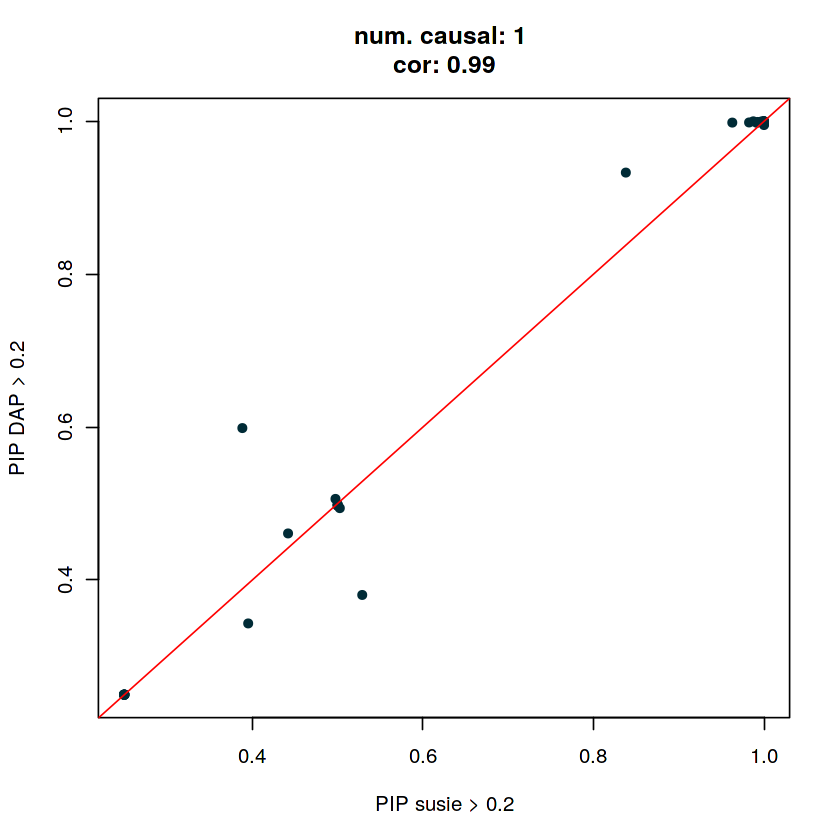

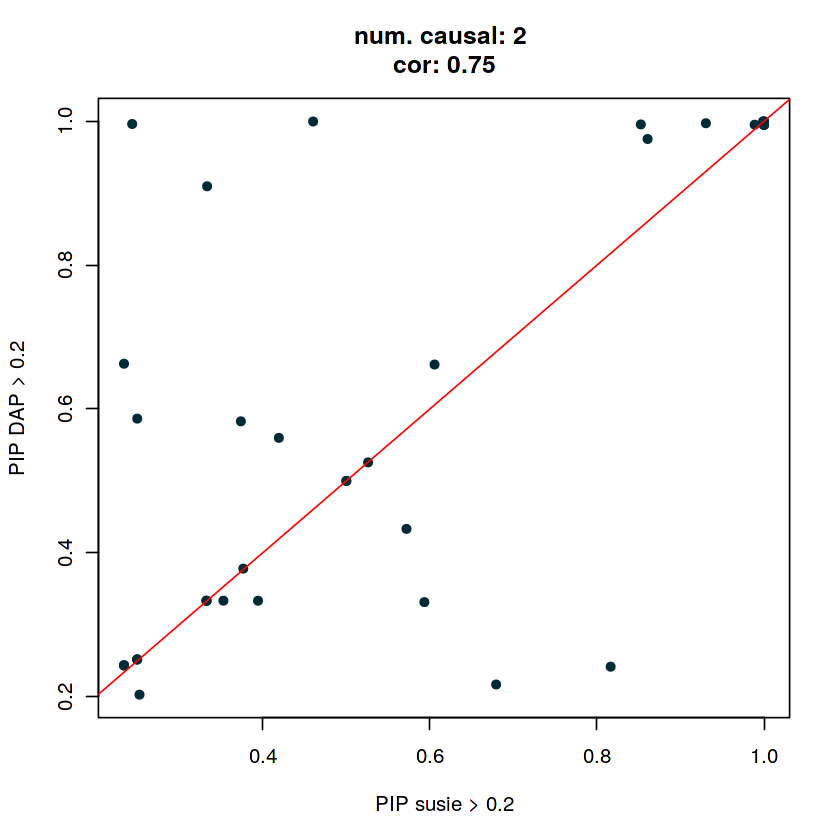

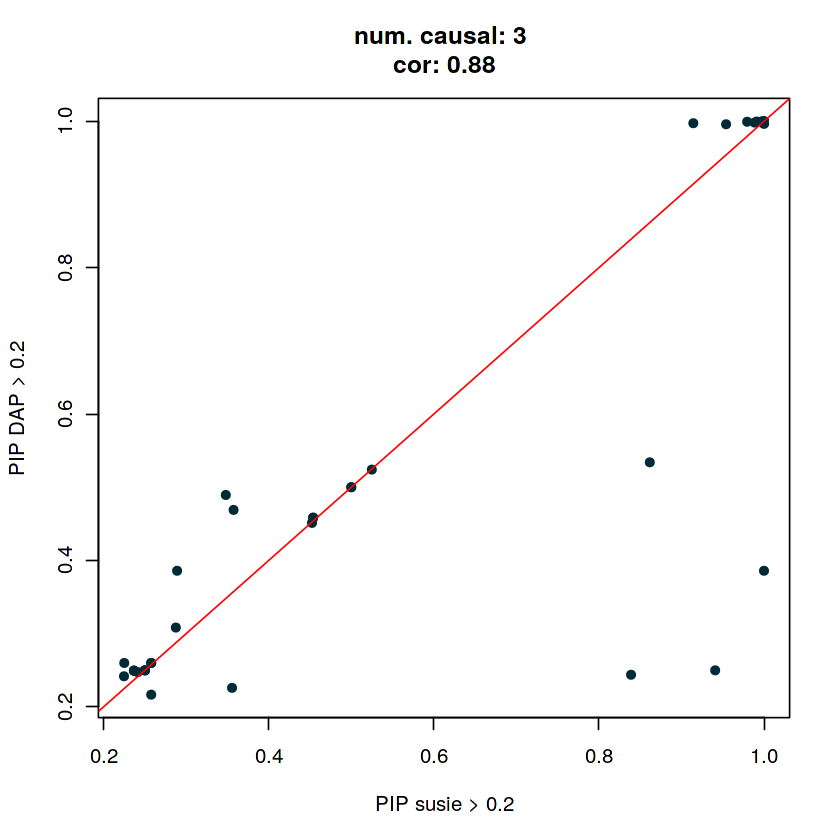

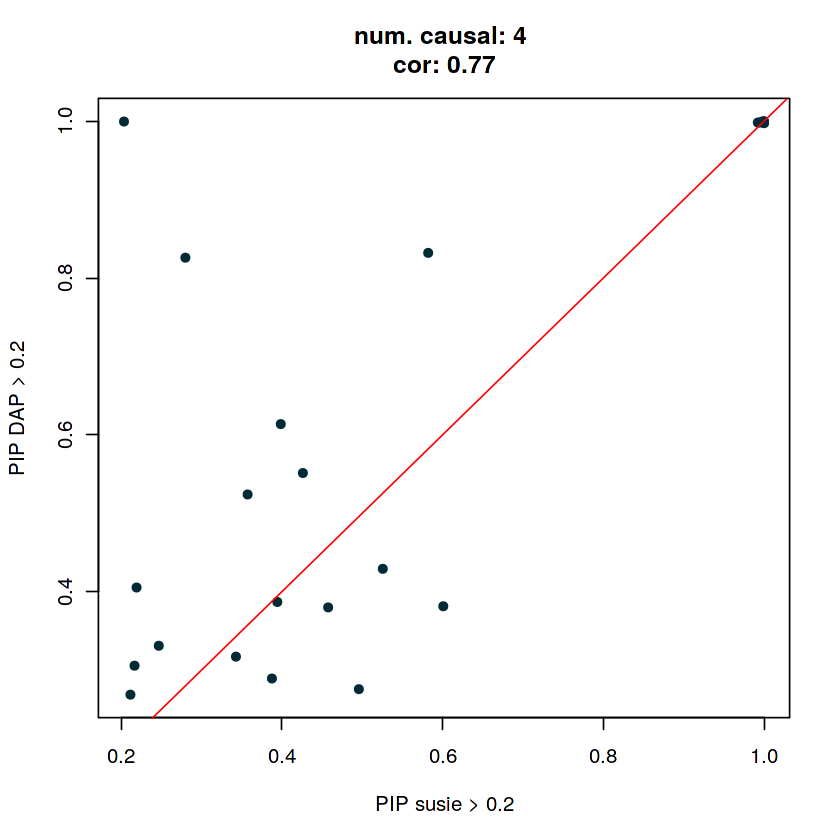

png 
  3

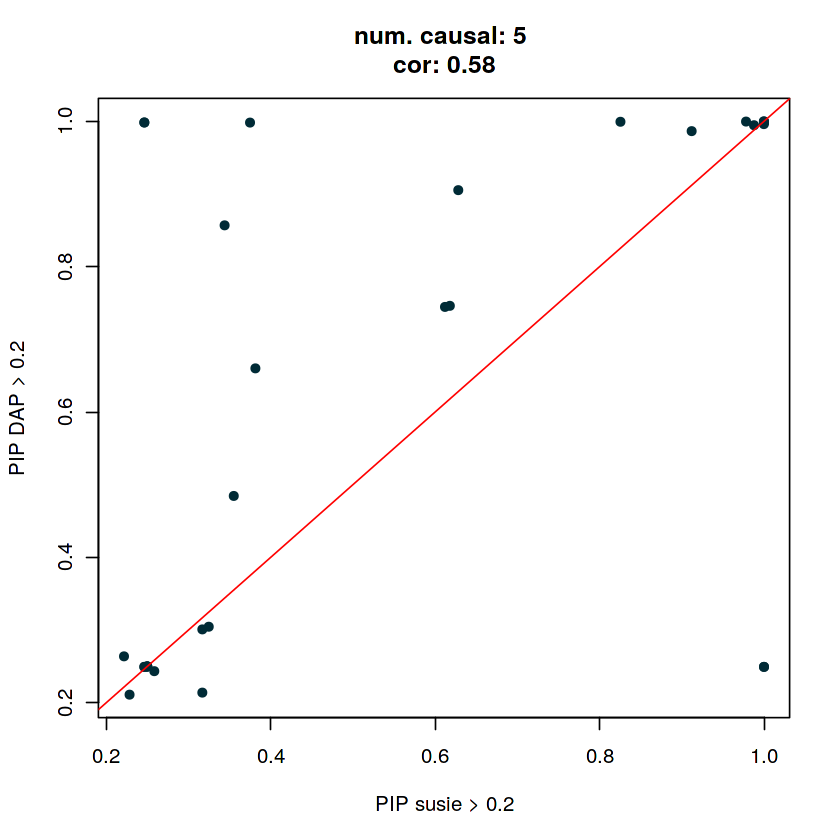

In [126]:
for (i in 1:5) {
    i = as.character(i)
    x = result[[i]][result[[i]]$susie > pip_cutoff & result[[i]]$dap > pip_cutoff,]
    plot(x[,1], x[,2], xlab = paste('PIP susie >', pip_cutoff), ylab = paste('PIP DAP >', pip_cutoff),
         main = paste('num. causal:', i, '\ncor:', round(cor(x)[1,2],2)),
        col = '#002b36', pch = 16)
    abline(0,1,col=2)
}
dev.off()